<a href="https://colab.research.google.com/github/dsobhani8/Env_Adjusted_TM/blob/main/Env_TM_model_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dsobhani8/Env_Adjusted_TM

Cloning into 'Env_Adjusted_TM'...
remote: Enumerating objects: 111, done.
remote: Total 111 (delta 0), reused 0 (delta 0), pack-reused 111
Receiving objects: 100% (111/111), 15.25 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
import numpy as np
import pandas as pd
import itertools as it
import math
import csv

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal, Distribution, HalfCauchy, Laplace

import nltk
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checks whether a GPU is available and chooses the GPU if it is

In [ ]:
file_path = "/content/Env_Adjusted_TM/data/political_stopwords.txt"

with open(file_path, 'r') as file:
    stopwords_list = file.readlines()

all_stopwords = [word.strip() for word in stopwords_list]

In [ ]:
class LemmaTokenizer:
	def __init__(self):
		self.wnl = WordNetLemmatizer()
	def __call__(self, doc):
		return [t for t in word_tokenize(doc) if str.isalpha(t)]

In [ ]:
train_data = pd.read_csv('/content/Env_Adjusted_TM/data/local_channels.csv')

# Set a seed for reproducibility
seed = 42

# Sample 20% for test1 and test2 using the same random state
test1 = train_data[train_data['source'] == 'right'].sample(frac=0.2, random_state=seed)
test2 = train_data[train_data['source'] == 'left'].sample(frac=0.2, random_state=seed)

# Drop the sampled rows from train_data
train_data = train_data.drop(test1.index)
train_data = train_data.drop(test2.index)

In [ ]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 1), stop_words=all_stopwords, max_df=0.4, min_df=0.0006)

docs_word_matrix_raw = vectorizer.fit_transform(train_data['text'])

env_mapping = {value: index for index, value in enumerate(train_data['source'].unique())}
env_index = train_data['source'].apply(lambda x: env_mapping[x])

docs_word_matrix_tensor = torch.from_numpy(docs_word_matrix_raw.toarray()).float().to(device)
env_index_tensor = torch.from_numpy(env_index.to_numpy()).long().to(device)


#style tokenizer for ood test
# vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
#                              ngram_range=(1, 1),
#                              stop_words=all_stopwords,
#                              max_df=0.5,
#                              min_df=0.006)

# # Fit the vectorizer on the combined dataset
# vectorizer.fit(combined_data['text'])

# # Only transform the train_data['text'] without fitting again
# docs_word_matrix_raw = vectorizer.transform(train_data['text'])

# env_mapping = {value: index for index, value in enumerate(train_data['source'].unique())}
# env_index = train_data['source'].apply(lambda x: env_mapping[x])

# docs_word_matrix_tensor = torch.from_numpy(docs_word_matrix_raw.toarray()).float().to(device)
# env_index_tensor = torch.from_numpy(env_index.to_numpy()).long().to(device)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sha', 'words'] not in stop_words.
  warnings.warn(


In [ ]:
class EnvTM(nn.Module):
    def __init__(self, num_topics, num_words, num_envs, device='cpu'):
        super(EnvTM, self).__init__()

        def init_param(shape):
            return nn.Parameter(torch.randn(shape, device=device))

        def init_param_zeros(shape):
            return nn.Parameter(torch.zeros(shape, device=device))

        self.num_topics, self.num_words, self.num_envs = num_topics, num_words, num_envs

        # Global Beta, β_{0,k} ~ 𝒩(·,·)
        self.beta = init_param([num_topics, num_words])
        self.beta_logvar = init_param_zeros([num_topics, num_words])
        self.beta_prior = Normal(torch.zeros([num_topics, num_words], device=device), torch.ones([num_topics, num_words], device=device))

        # Lambda parameters, λ_{e,k} ~ Half-Cauchy(0,_)
        self.lambda_ek = torch.distributions.HalfCauchy(scale=torch.tensor(0.4, device=device)).rsample([num_envs, num_topics])

        # Expand lambda_ek to have the same shape across words
        self.lambda_ek = self.lambda_ek.unsqueeze(-1).expand(-1, -1, num_words)

        # Tau parameter, τ ~ Half-Cauchy(0, _)
        self.tau = torch.distributions.HalfCauchy(scale=torch.tensor(0.4, device=device)).rsample()

        # Gamma parameters, γ_{e,k} ~ 𝒩(0, λ_{e,k}^2 τ^2)
        self.gamma = init_param_zeros([num_envs, num_topics, num_words])
        self.gamma_logvar = init_param_zeros([num_envs, num_topics, num_words])

        gamma_prior_variance = (self.lambda_ek ** 2) * (self.tau ** 2)

        # Since gamma is Normal(0, λ_{e,k}^2 τ^2)
        self.gamma_prior = Normal(torch.zeros_like(gamma_prior_variance), torch.sqrt(gamma_prior_variance).add(1e-8))

        # Global Theta, θ_{d} ~ 𝒩(·,·)
        self.theta_global_prior = Normal(torch.zeros(num_topics, device=device), torch.ones(num_topics, device=device))

        self.theta_global_net = nn.Sequential(
            nn.Linear(num_words, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, num_topics * 2)
        )


    def forward(self, bow, env_index):
        batch_size, vocab_size = bow.size()

        # Compute document-specific theta_global mean and variance
        self.theta_global_params = self.theta_global_net(bow)
        theta_global_mu, theta_global_logvar = self.theta_global_params.split(self.num_topics, dim=-1)
        theta_global_logvar = theta_global_logvar.add(1e-8)

        # Sample 𝜃_{d} from the Normal distribution
        theta_global = Normal(theta_global_mu, torch.exp(0.5 * theta_global_logvar).add(1e-8)).rsample()
        theta_softmax = F.softmax(theta_global, dim=-1)

        # Sample global beta (β₀,k)
        beta_dist = Normal(self.beta, torch.exp(0.5 * self.beta_logvar).add(1e-8))
        beta_sample = beta_dist.rsample()

        # Generate gamma (γ_{e,k,v}) variance and sample gamma
        gamma_dist = Normal(self.gamma[env_index], torch.exp(0.5 * self.gamma_logvar[env_index]).add(1e-8))
        gamma_sample = gamma_dist.rsample()

        beta_gamma_softmax = F.softmax(beta_sample + gamma_sample, dim=-1)

        # Combine theta and beta_ek_sample
        z = theta_softmax @ beta_gamma_softmax
        return z

In [ ]:
def calculate_kl_divergences(EnvTM, env):
    theta_global_mu, theta_global_logvar = EnvTM.theta_global_params.split(EnvTM.num_topics, dim=-1)
    theta_global_logvar = theta_global_logvar.add(1e-8)
    theta_global = Normal(theta_global_mu, torch.exp(0.5 * theta_global_logvar).add(1e-8))
    theta_global_kl = torch.distributions.kl.kl_divergence(theta_global, EnvTM.theta_global_prior).sum()

    beta = Normal(EnvTM.beta, torch.exp(0.5 * EnvTM.beta_logvar))
    beta_kl = torch.distributions.kl.kl_divergence(beta, EnvTM.beta_prior).sum()

    gamma = Normal(EnvTM.gamma[env], torch.exp(0.5 * EnvTM.gamma_logvar[env]).add(1e-8))
    gamma_kl = torch.distributions.kl.kl_divergence(gamma, EnvTM.gamma_prior).sum()

    return theta_global_kl, beta_kl, gamma_kl

In [ ]:
def bbvi_update(minibatch, env_index, EnvTM, optimizer, n_samples):
    optimizer.zero_grad()
    elbo_accumulator = torch.zeros(1, device=minibatch.device)

    # Get the unique environment indexes
    unique_envs = torch.unique(env_index)

    for env in unique_envs:
        # Get the mask where current environment matches
        mask = (env_index == env)

        # Use the mask to get the current minibatch and number of samples
        current_minibatch = minibatch[mask]
        if current_minibatch.size(0) <= 1:
            continue
        current_n_samples = n_samples * mask.sum().item() / minibatch.size()[0]
        # Pass the current minibatch to the model
        z = EnvTM(current_minibatch, env)
        theta_global_params = EnvTM.theta_global_net(current_minibatch)

        theta_global_kl, beta_kl, gamma_kl = calculate_kl_divergences(EnvTM, env)
        elbo = (current_minibatch * z.log()).sum(-1).mul(current_n_samples).sub(theta_global_kl + beta_kl + gamma_kl)
        elbo_accumulator += elbo.sum()

    (-elbo_accumulator).backward()
    optimizer.step()

    return elbo_accumulator.item()

In [ ]:
def train_model(EnvTM, docs_word_matrix_tensor, env_index_tensor, num_epochs=80, minibatch_size=1024, lr=0.01):
    EnvTM = EnvTM.to(device)
    optimizer = torch.optim.Adam(EnvTM.parameters(), lr=lr, betas=(0.9, 0.999))

    docs_word_matrix_tensor = docs_word_matrix_tensor.to(device)
    env_index_tensor = env_index_tensor.to(device)

    for epoch in range(num_epochs):
        elbo_accumulator = 0.0

        # Randomly permute data for minibatches
        permutation = torch.randperm(docs_word_matrix_tensor.size()[0])

        for i in range(0, docs_word_matrix_tensor.size()[0], minibatch_size):
            # Get minibatch
            indices = permutation[i:i+minibatch_size]
            minibatch = docs_word_matrix_tensor[indices]

            # Get corresponding environment indices
            minibatch_env_index = env_index_tensor[indices]

            # BBVI update for the minibatch
            elbo = bbvi_update(minibatch, minibatch_env_index, EnvTM, optimizer, docs_word_matrix_tensor.size()[0])

            # Accumulate ELBO
            elbo_accumulator += elbo

        # Calculate average ELBO for the epoch
        avg_elbo = elbo_accumulator / (docs_word_matrix_tensor.size()[0] / minibatch_size)

        print(f'Epoch: {epoch+1}, Average ELBO: {avg_elbo}')


In [ ]:
num_topics = 20
num_envs = 2
num_epoch = 150
env_tm_model = EnvTM(num_topics=num_topics, num_words=len(vectorizer.get_feature_names_out()), num_envs=num_envs, device=device)

train_model(env_tm_model, docs_word_matrix_tensor, env_index_tensor, num_epochs=num_epoch, minibatch_size=1024, lr=0.01)

Epoch: 1, Average ELBO: -2754843116.9943757
Epoch: 2, Average ELBO: -2612923521.501527
Epoch: 3, Average ELBO: -2521935813.4198937
Epoch: 4, Average ELBO: -2459751711.7994537
Epoch: 5, Average ELBO: -2414896832.44223
Epoch: 6, Average ELBO: -2381231440.5065084
Epoch: 7, Average ELBO: -2357505028.442873
Epoch: 8, Average ELBO: -2338399007.0589747
Epoch: 9, Average ELBO: -2322562029.4057527
Epoch: 10, Average ELBO: -2309441986.540254
Epoch: 11, Average ELBO: -2299327305.8421984
Epoch: 12, Average ELBO: -2285727843.388719
Epoch: 13, Average ELBO: -2275571680.077133
Epoch: 14, Average ELBO: -2270348446.133376
Epoch: 15, Average ELBO: -2259220197.9598265
Epoch: 16, Average ELBO: -2248986909.002089
Epoch: 17, Average ELBO: -2239768280.137554
Epoch: 18, Average ELBO: -2229844560.053993
Epoch: 19, Average ELBO: -2223302499.6766834
Epoch: 20, Average ELBO: -2213430361.6802187
Epoch: 21, Average ELBO: -2205503559.744175
Epoch: 22, Average ELBO: -2197436534.147517
Epoch: 23, Average ELBO: -219016

In [ ]:
def print_top_words(env_tm_model, vectorizer, num_top_words):
    global_beta = torch.nn.functional.softmax(env_tm_model.beta, dim=1)  # Convert to probabilities
    gamma = env_tm_model.gamma

    # Print top words for global beta
    print("Top words for global beta:")
    for i, topic in enumerate(global_beta):
        top_words = topic.topk(num_top_words).indices
        print(f'Topic {i+1}: {[vectorizer.get_feature_names_out()[i] for i in top_words]}')

    # Print top words for gamma
    print("\nTop words for gamma:")
    for env_index, env_gamma in enumerate(gamma):
        print(f"Environment {env_index+1}:")
        for i, topic in enumerate(env_gamma):
            top_words = topic.topk(num_top_words).indices
            print(f'Topic {i+1}: {[vectorizer.get_feature_names_out()[i] for i in top_words]}')
        print()

In [ ]:
print_top_words(env_tm_model, vectorizer, num_top_words=5)

Top words for global beta:
Topic 1: ['families', 'truth', 'tried', 'newspapers', 'stood']
Topic 2: ['tax', 'health', 'billion', 'dollars', 'issue']
Topic 3: ['governor', 'insurance', 'companies', 'lower', 'rates']
Topic 4: ['job', 'spending', 'debt', 'started', 'water']
Topic 5: ['liberal', 'violence', 'supports', 'laws', 'attack']
Topic 6: ['voted', 'law', 'county', 'federal', 'spent']
Topic 7: ['money', 'plan', 'america', 'economy', 'nation']
Topic 8: ['jobs', 'class', 'middle', 'democrat', 'workers']
Topic 9: ['protect', 'fight', 'energy', 'oil', 'gas']
Topic 10: ['billions', 'millions', 'social', 'security', 'benefits']
Topic 11: ['government', 'politicians', 'politics', 'politician', 'political']
Topic 12: ['taxes', 'schools', 'budget', 'cut', 'supported']
Topic 13: ['pay', 'court', 'women', 'choose', 'raises']
Topic 14: ['taxpayers', 'mayor', 'public', 'leadership', 'local']
Topic 15: ['content', 'responsible', 'rights', 'democratic', 'national']
Topic 16: ['family', 'help', 'oba

In [ ]:
test_data_word_matrix_raw = vectorizer.transform(test1['text'])
test_data_word_matrix_tensor = torch.from_numpy(test_data_word_matrix_raw.toarray()).float().to(device)

In [ ]:
def evaluate_model(env_tm_model, test_data_word_matrix_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env_tm_model.to(device)
    env_tm_model.eval()

    with torch.no_grad():
        theta_test_params = env_tm_model.theta_global_net(test_data_word_matrix_tensor)
        theta_test_mu, theta_test_logvar = theta_test_params.split(env_tm_model.num_topics, dim=-1)
        theta_test_dist = Normal(theta_test_mu, torch.exp(0.5 * theta_test_logvar).add(1e-8))
        theta_test = theta_test_dist.rsample()
        theta_test_softmax = F.softmax(theta_test, dim=-1)
        beta_test_softmax = F.softmax(env_tm_model.beta.to(device), dim=-1)

        likelihood = torch.mm(theta_test_softmax, beta_test_softmax)
        N = torch.sum(test_data_word_matrix_tensor)
        log_perplex = -torch.sum(torch.log(likelihood) * test_data_word_matrix_tensor) / N
        perplexity = torch.exp(log_perplex)

    return perplexity, theta_test_softmax

def evaluate_model_with_gamma_per_env(env_tm_model, test_data_word_matrix_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env_tm_model.to(device)
    env_tm_model.eval()


    with torch.no_grad():
        theta_test_params = env_tm_model.theta_global_net(test_data_word_matrix_tensor)
        theta_test_mu, theta_test_logvar = theta_test_params.split(env_tm_model.num_topics, dim=-1)
        theta_test_dist = Normal(theta_test_mu, torch.exp(0.5 * theta_test_logvar).add(1e-8))
        theta_test = theta_test_dist.rsample()
        theta_test_softmax = F.softmax(theta_test, dim=-1)

        gamma_learned = env_tm_model.gamma[0]

        beta_gamma_test_softmax = F.softmax(env_tm_model.beta.to(device) + gamma_learned, dim=-1)
        log_likelihood = torch.mm(theta_test_softmax, beta_gamma_test_softmax)
        N = torch.sum(test_data_word_matrix_tensor)
        log_perplex = -torch.sum(torch.log(log_likelihood) * test_data_word_matrix_tensor) / N
        perplexity = torch.exp(log_perplex)

    return perplexity

In [ ]:
perplexity, theta_test_softmax = evaluate_model(env_tm_model, test_data_word_matrix_tensor)
perplexities_by_env = evaluate_model_with_gamma_per_env(env_tm_model, test_data_word_matrix_tensor)

print(f'Perplexity for environment {0} effects: {perplexities_by_env}')

print(f'Test Perplexity: {perplexity}')

Perplexity for environment 0 effects: 577.8445434570312
Test Perplexity: 751.1364135742188


Top words in gamma environment 0: ['afford', 'cuts', 'plans', 'code', 'mandates', 'percent', 'history', 'eliminate']
Top words in beta:                ['tax', 'health', 'billion', 'dollars', 'issue', 'increase', 'sales', 'breaks']


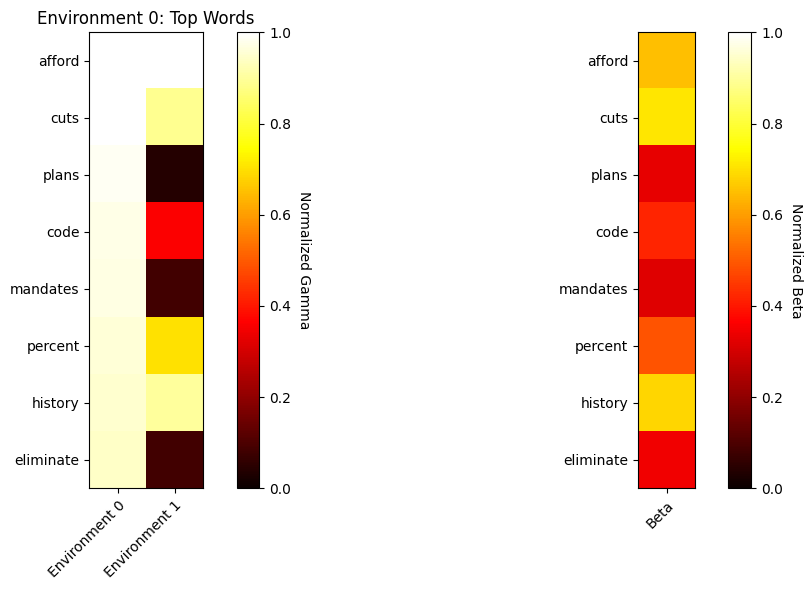

Top words in gamma environment 1: ['afford', 'supports', 'unfair', 'grocery', 'topinka', 'repeal', 'soda', 'stroger']
Top words in beta:                ['tax', 'health', 'billion', 'dollars', 'issue', 'increase', 'sales', 'breaks']


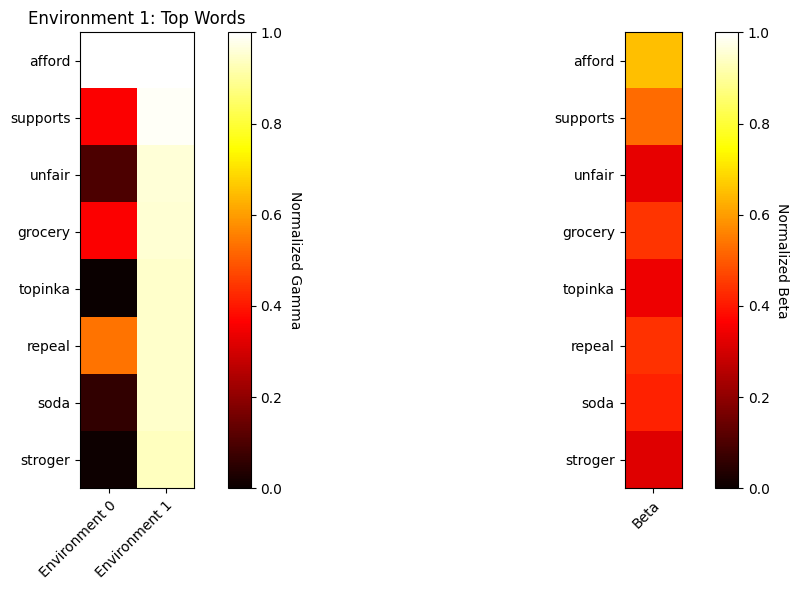

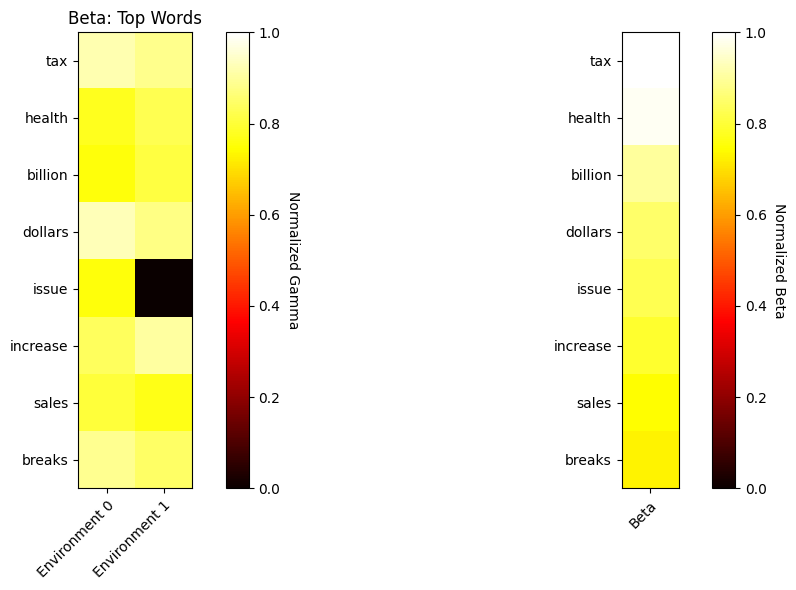

In [ ]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def get_top_indices_values(arr, top_n=8):
    indices = np.argsort(-arr)[:top_n]
    values = arr[indices]
    return indices, values

def get_words(vocabulary, indices):
    return [vocabulary[i] for i in indices]

def plot_gamma_beta_heatmaps(gamma_data, beta_data, words, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Defining the color scale between 0 and 1
    im1 = ax1.imshow(gamma_data.T, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    im2 = ax2.imshow(beta_data.T.reshape(-1, 1), cmap='hot', interpolation='nearest', vmin=0, vmax=1)

    num_environments = gamma_data.shape[0]
    environments = [f'Environment {i}' for i in range(num_environments)]

    # Settings for gamma heatmap
    ax1.set_yticks(np.arange(len(words)))
    ax1.set_xticks(np.arange(num_environments))
    ax1.set_yticklabels(words)
    ax1.set_xticklabels(environments)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("Normalized Gamma", rotation=-90, va="bottom")

    # Settings for beta grid
    ax2.set_yticks(np.arange(len(words)))
    ax2.set_xticks([0])
    ax2.set_yticklabels(words)
    ax2.set_xticklabels(['Beta'])
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar2 = fig.colorbar(im2, ax=ax2)
    cbar2.ax.set_ylabel("Normalized Beta", rotation=-90, va="bottom")

    ax1.set_title(title)
    fig.tight_layout()
    plt.show()

def analyze_topic(lda, vocabulary, topic_index, top_n=8):
    # Normalize the entire beta array for the specific topic
    beta_values = normalize(lda.beta[topic_index, :].cpu().detach().numpy())

    # Normalize the entire gamma arrays for the specific topic in all environments
    num_environments = lda.gamma.shape[0]
    gamma_values = [normalize(lda.gamma[i, topic_index, :].cpu().detach().numpy()) for i in range(num_environments)]

    # Get the top beta indices and values
    beta_indices, _ = get_top_indices_values(beta_values, top_n)

    for env_index, gamma_value in enumerate(gamma_values):
        # Get the top gamma indices and values
        gamma_indices, _ = get_top_indices_values(gamma_value, top_n)

        # Get the corresponding words from the vocabulary
        gamma_words = get_words(vocabulary, gamma_indices)
        beta_words = get_words(vocabulary, beta_indices)

        # Print the top words
        print(f"Top words in gamma environment {env_index}:", gamma_words)
        print("Top words in beta:               ", beta_words)

        # Get the gamma and beta values for top words
        gamma_values_top_words = [gamma_values[i][gamma_indices] for i in range(num_environments)]
        beta_values_top_words = beta_values[gamma_indices]

        # Plot the heatmaps
        plot_gamma_beta_heatmaps(np.array(gamma_values_top_words), beta_values_top_words, gamma_words, f"Environment {env_index}: Top Words")

    # Gamma and Beta values for top words in beta
    gamma_values_beta = [gamma_values[i][beta_indices] for i in range(num_environments)]
    beta_values_beta = beta_values[beta_indices]
    beta_words = get_words(vocabulary, beta_indices)

    # Plot the heatmaps for the top words in beta
    plot_gamma_beta_heatmaps(np.array(gamma_values_beta), beta_values_beta, beta_words, "Beta: Top Words")


vocabulary = list(vectorizer.get_feature_names_out())

# Analyzing topic 4 with 8 top words
analyze_topic(env_tm_model, vocabulary, topic_index=1, top_n=8)

In [ ]:
def analyze_gamma_per_environment(model, threshold=1e-3):
    gamma_values = model.gamma.detach().cpu().numpy()

    for env_index in range(gamma_values.shape[0]):
        print(f"Environment {env_index}:")
        gamma_env_values = gamma_values[env_index]

        close_to_zero = np.abs(gamma_env_values) < threshold
        sparsity_percentage = 100 * np.sum(close_to_zero) / gamma_env_values.size

        print(f"Sparsity Percentage: {sparsity_percentage}%")
        print(f"Mean of Gamma: {np.mean(gamma_env_values)}")
        print(f"Standard Deviation of Gamma: {np.std(gamma_env_values)}")
        plt.hist(gamma_env_values.flatten(), bins=50)
        plt.title(f"Histogram of Gamma Values for Environment {env_index}")
        plt.show()


Environment 0:
Sparsity Percentage: 0.749554594044286%
Mean of Gamma: -0.004756218753755093
Standard Deviation of Gamma: 0.31899502873420715


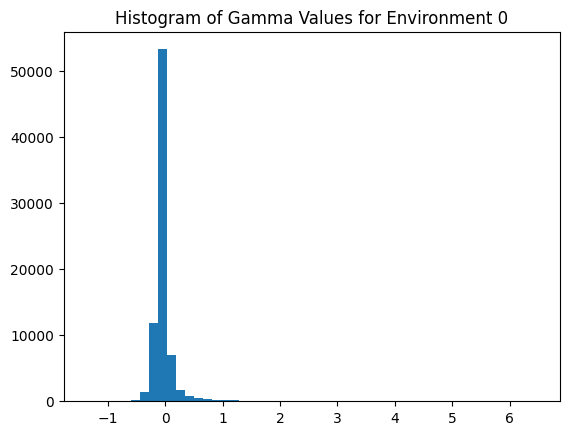

Environment 1:
Sparsity Percentage: 0.6133876304403156%
Mean of Gamma: -0.004975227639079094
Standard Deviation of Gamma: 0.34954360127449036


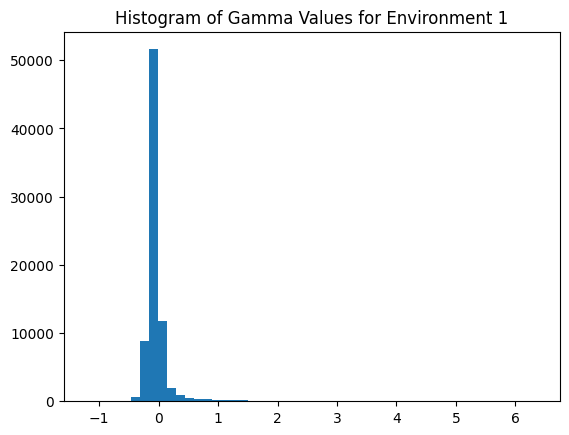

In [ ]:
analyze_gamma_per_environment(env_tm_model)
